# Company

In [2]:
pd.read_parquet('../Data/trading_data_after_eda_5years.parquet')

,website,section,url,header,body,key_words,body_length,datetime
0,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/644973,"Нефть Brent подешевела до $54,25 за баррель",- Цены на нефть снижаются в четверг после по...,[Brent],2101,2019-01-03 09:38:00
1,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/644976,Рынок акций РФ открылся снижением индексов Мос...,- Рынок акций РФ на первых в новом году торг...,[рынок акций],1961,2019-01-03 10:18:00
2,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/644980,Доллар в моменте обновил максимум марта 2016 г...,"По данным аналитиков, доллар вырос из-за разов...","[курсы валют, рубль, евро, доллар]",1048,2019-01-03 10:42:00
3,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514388.php,Банк Открытие и Бинбанк - процесс объединения ...,"Банк ""ФК Открытие"" и Бинбанк — завершили проце...","[ФК Открытие, Бинбанк, Открытие]",882,2019-01-03 11:24:00
4,Ria,Экономика,https://ria.ru/20190103/1549006636.html,Рубль открыл год ростом к доллару и евро,Рубль открыл первые торги нового года уверен...,"[Экономика, Россия]",375,2019-01-03 11:49:00
...,...,...,...,...,...,...,...,...
169843,Kommersant,Финансы,https://www.kommersant.ru/doc/6440789,ЦБ изучит связанные с криптоактивами трансгран...,Банк России планирует в начале 2024 года изучи...,[],1529,2023-12-29 20:52:00
169844,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938589,JD.com выиграла антимонопольное дело против ко...,- Китайская интернет-компания JD.com Inc. вы...,"[Alibaba, JD.com, Tmall, Китай]",675,2023-12-29 20:52:00
169845,Ria,Экономика,https://ria.ru/20231229/ssha-1919057051.html,"В США призвали ставить маячки на оборудование,...",Два американских эксперта в статье для New Y...,"[Экономика, Китай, США, Технологии, Россия, Ap...",1773,2023-12-29 21:00:00
169846,Ria,Экономика,https://ria.ru/20231229/kapital-1919057431.html,"Глава ""Иннопрактики"" и ее первый зам вошли в к...","Глава российского института развития ""Иннопр...","[Экономика, Технологии, Россия, Наталия Попова...",2063,2023-12-29 21:01:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

import re
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import requests
import datetime
import time
from random import uniform, randint

In [2]:
username = '...'
password = '...'
host = '...'
port = '...'
database = '...'
conn_string = f'postgresql://{username}:{password}@{host}:{port}/{database}'

## Data import

In [3]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

companies_df = pd.read_sql_query('SELECT * FROM data.companies_tickets', conn)
conn.close()

## Downloading data from Moscow Exchange and enriching the existing dataset

In [4]:
companies_string = 'http://iss.moex.com/iss/engines/stock/markets/shares/securities/{}/candles.json?from={}&till={}&interval=1'

In [5]:
companies_df['price_release'] = np.nan
companies_df['volume_release'] = np.nan
companies_df['price_lag_30'] = np.nan
companies_df['volume_lag_30'] = np.nan

In [6]:
companies_df = companies_df.sort_values(by=['datetime'])

In [7]:
for i in tqdm(range(len(companies_df))):
    start = companies_df['datetime'][i]
    end = companies_df['datetime'][i] + datetime.timedelta(minutes=30)
    company = companies_df['company'][i]
    connect_timeout = 300
    read_timeout = 120
    n = requests.get(companies_string.format(company, start, end), timeout=(connect_timeout, read_timeout)).json()
    try:
        companies_df.loc[i, 'price_release'] = n['candles']['data'][0][0]
        companies_df.loc[i, 'volume_release'] = n['candles']['data'][0][4]
        companies_df.loc[i, 'price_lag_30'] = n['candles']['data'][-1][0]
        companies_df.loc[i, 'volume_lag_30'] = n['candles']['data'][-1][4]
    except IndexError:
        continue
#     if i % randint() == 0:
#         delay = uniform(5, 10)
#         time.sleep(delay)

100%|████████████████████████████████████████████████████████████| 7542/7542 [09:32<00:00, 13.17it/s]


In [8]:
companies_df.isna().sum()

website             0
section             0
url                 0
header              0
body                0
tags              733
body_length         0
datetime            0
company             0
price_release     275
volume_release    275
price_lag_30      275
volume_lag_30     275
dtype: int64

> **Comment:** We have 275 NAs, this is due to the fact that on that day there were certain problems with a specific instrument: trading was suspended or data was corrupted. We can’t do anything about this, so we just removed these observations

In [9]:
companies_df = companies_df.dropna(subset=['price_release'])

## Getting the differences

In [10]:
companies_df['price_diff'] = companies_df['price_lag_30'] - companies_df['price_release']
companies_df['price_diff_percent'] = companies_df['price_diff'] / companies_df['price_release'] * 100
companies_df['volume_diff'] = companies_df['volume_lag_30'] - companies_df['volume_release']
companies_df['volume_diff_percent'] = companies_df['volume_diff'] / companies_df['volume_release'] * 100

## Some observations

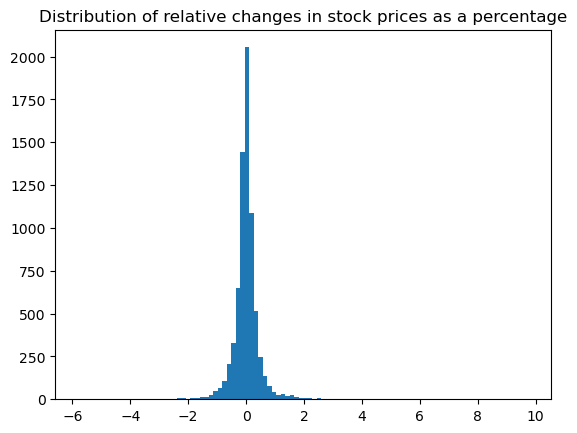

In [11]:
plt.hist(companies_df.price_diff_percent, bins=100)
plt.title('Distribution of relative changes in stock prices as a percentage')
plt.show()

> **Comment:** It is easy to see that the distribution turned out to be quite logical: symmetrical and with a strong kurtosis at zero

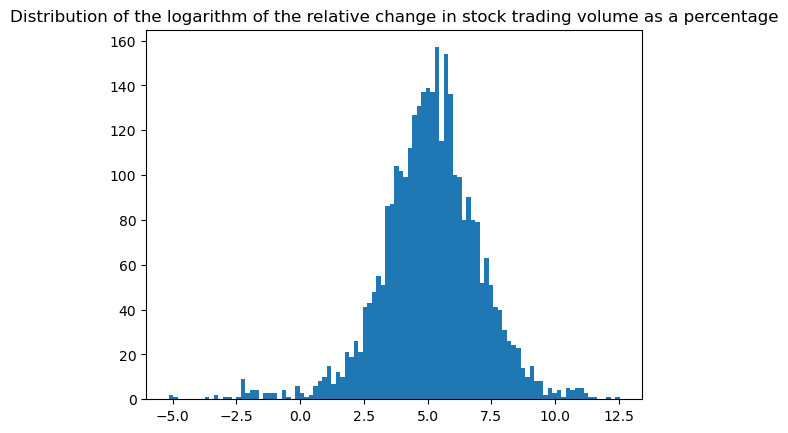

In [14]:
plt.hist(np.log(companies_df.volume_diff_percent+0.1), bins=100)
plt.title('Distribution of the logarithm of the relative change in stock trading volume as a percentage')
plt.show()

> **Comment:** We found that the relative change in stock trading volume has approximately a log-normal distribution

## Export and Check

In [16]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True
companies_df.to_sql('companies_trade', con=conn, if_exists='replace', index=False) 
conn.close()

In [18]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

dataframe = pd.read_sql_query('SELECT * FROM data.companies_trade', conn)
conn.close()

print(dataframe.shape)
dataframe.head()

# Industry

## Data import

In [19]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

ind_df = pd.read_sql_query('SELECT * FROM data.industries_tickets', conn)
conn.close()

## Downloading data from Moscow Exchange and enriching the existing dataset

In [20]:
ind_string = 'http://iss.moex.com/iss/engines/stock/markets/index/boards/SNDX/securities/{}/candles.json?from={}&till={}&interval=1'

In [21]:
ind_df['price_release'] = np.nan
ind_df['volume_release'] = np.nan
ind_df['price_lag_30'] = np.nan
ind_df['volume_lag_30'] = np.nan

In [22]:
ind_df = ind_df.sort_values(by=['datetime'])

In [23]:
for i in tqdm(range(len(ind_df))):
    start = ind_df['datetime'][i]
    end = ind_df['datetime'][i] + datetime.timedelta(minutes=30)
    ind = ind_df['industry'][i]
    connect_timeout = 100000
    read_timeout = 100000
    n = requests.get(ind_string.format(ind, start, end), timeout=(connect_timeout, read_timeout)).json()
    try:
        ind_df.loc[i, 'price_release'] = n['candles']['data'][0][0]
        ind_df.loc[i, 'volume_release'] = n['candles']['data'][0][4]
        ind_df.loc[i, 'price_lag_30'] = n['candles']['data'][-1][0]
        ind_df.loc[i, 'volume_lag_30'] = n['candles']['data'][-1][4]
    except IndexError:
        continue
#     delay = uniform(0, 3)
#     time.sleep(delay)

100%|████████████████████████████████████████████████████████████| 6228/6228 [08:32<00:00, 12.15it/s]


In [24]:
ind_df.isna().sum()

website              0
section              0
url                  0
header               0
body                 0
tags               564
body_length          0
datetime             0
industry             0
price_release     1473
volume_release    1473
price_lag_30      1473
volume_lag_30     1473
dtype: int64

> **Comment:** We got 1473 NAs, this is due to the fact that, unlike other instruments that we consider, industrial indices have a narrower time window for trading, as a result, a significant part of the observations in our sample are not suitable, since these observations do not fall into this window. We can’t do anything about this, so we just remove these observations

In [25]:
ind_df = ind_df.dropna(subset=['price_release'])

## Getting the differences

In [26]:
ind_df['price_diff'] = ind_df['price_lag_30'] - ind_df['price_release']
ind_df['price_diff_percent'] = ind_df['price_diff'] / ind_df['price_release'] * 100
ind_df['volume_diff'] = ind_df['volume_lag_30'] - ind_df['volume_release']
ind_df['volume_diff_percent'] = ind_df['volume_diff'] / ind_df['volume_release'] * 100

## Some observations

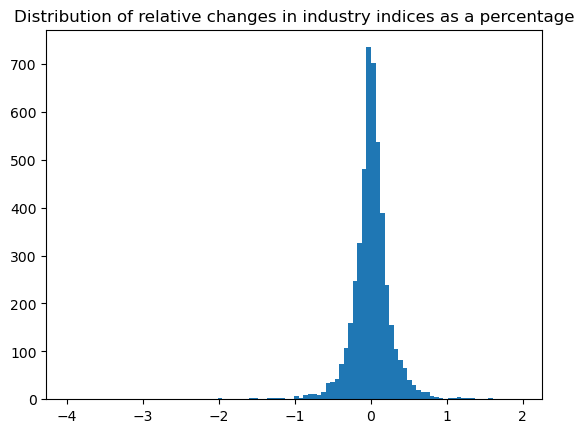

In [27]:
plt.hist(ind_df.price_diff_percent, bins=100)
plt.title('Distribution of relative changes in industry indices as a percentage')
plt.show()

> **Comment:** It is easy to see that the distribution turned out to be quite logical: symmetrical and with a strong kurtosis at zero

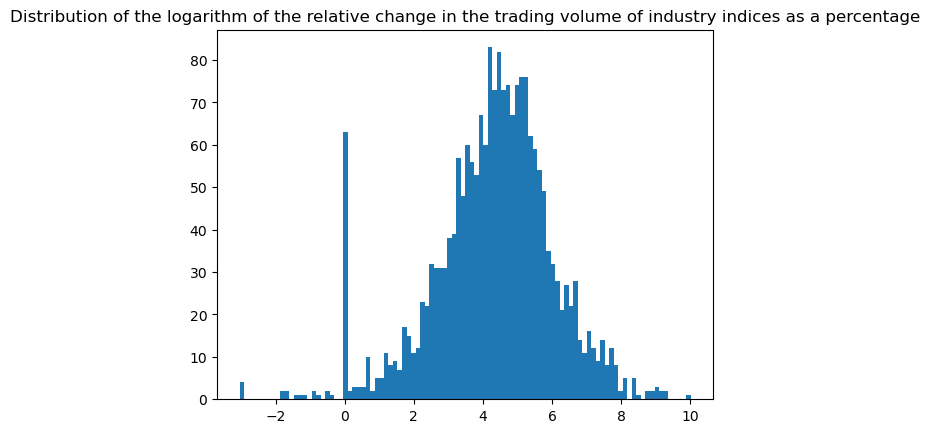

In [28]:
plt.hist(np.log(ind_df.volume_diff_percent+1), bins=100)
plt.title('Distribution of the logarithm of the relative change in the trading volume of industry indices as a percentage')
plt.show()

> **Comment:** We found that the relative change in stock trading volume has approximately a log-normal distribution with a "top" on the left caused by zeros

## Export and Check

In [97]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True
ind_df.to_sql('industries_trade', con=conn, if_exists='replace', index=False) 
conn.close()

In [98]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

dataframe = pd.read_sql_query('SELECT * FROM industries_trade', conn)
conn.close()

print(dataframe.shape)
dataframe.head()

(4755, 17)


,website,section,url,header,body,tags,body_length,datetime,industry,price_release,volume_release,price_lag_30,volume_lag_30,price_diff,price_diff_percent,volume_diff,volume_diff_percent
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,MOEXFN,6307.20,16806757.15,6308.77,11854100.00,1.57,0.024892,-4952657.15,-29.468250
1,РИА,Экономика,https://ria.ru/20230103/gazprom-1842940413.html,"Экспорт ""Газпрома"" снизился до минимума с конц...","Объём экспорта ""Газпрома"" в прошедшем году с...","['Экономика', 'Газпром', 'Россия']",1299,2023-01-03 14:22:00,MOEXOG,5696.30,4451180.75,5696.72,4605859.35,0.42,0.007373,154678.60,3.475002
2,РИА,Экономика,https://ria.ru/20230104/shelf-1843063413.html,Ямальской шельфовой компании предоставили два ...,Правительство РФ предоставило Ямальской шель...,"['Экономика', 'Карское море', 'Россия']",1719,2023-01-04 16:36:00,MOEXOG,5655.65,3325798.35,5663.65,1490555.35,8.00,0.141451,-1835243.00,-55.182029
3,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,MOEXFN,6298.36,7394623.45,6296.27,3371524.05,-2.09,-0.033183,-4023099.40,-54.405737
4,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,MOEXOG,5655.00,15940301.65,5647.93,1358915.70,-7.07,-0.125022,-14581385.95,-91.474969


# MOEX, RVI and RUNUSD futures

## Data import

In [30]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

global_df = pd.read_sql_query('SELECT * FROM data.global_tickets', conn)
conn.close()

## Downloading data from Moscow Exchange and enriching the existing dataset

In [31]:
global_moex = 'http://iss.moex.com/iss/engines/stock/markets/index/boards/SNDX/securities/IMOEX2/candles.json?from={}&till={}&interval=1'
global_rvi = 'http://iss.moex.com/iss/engines/stock/markets/index/boards/RTSI/securities/RVI/candles.json?from={}&till={}&interval=1'
global_usd_rub_fut = 'http://iss.moex.com/iss/engines/futures/markets/forts/boards/RFUD/securities/{}/candles.json?from={}&till={}&interval=1'

In [32]:
global_df['imoex_price_release'] = np.nan
# global_df['imoex_volume_release'] = np.nan
global_df['imoex_price_lag_30'] = np.nan
# global_df['imoex_volume_lag_30'] = np.nan

global_df['rvi_price_release'] = np.nan
global_df['rvi_price_lag_30'] = np.nan

global_df['usd_price_release'] = np.nan
global_df['usd_price_lag_30'] = np.nan

In [33]:
global_df = global_df.sort_values(by=['datetime'])

In [34]:
for i in tqdm(range(len(global_df))):
    start = global_df['datetime'][i]
    end = global_df['datetime'][i] + datetime.timedelta(minutes=30)
    connect_timeout = 300
    read_timeout = 120
    n = requests.get(global_moex.format(start, end), timeout=(connect_timeout, read_timeout)).json()
    try:
        global_df.loc[i, 'imoex_price_release'] = n['candles']['data'][0][0]
#         global_df.loc[i, 'imoex_volume_release'] = n['candles']['data'][0][4]
        global_df.loc[i, 'imoex_price_lag_30'] = n['candles']['data'][-1][0]
#         global_df.loc[i, 'imoex_volume_lag_30'] = n['candles']['data'][-1][4]
    except IndexError:
        continue
    n = requests.get(global_rvi.format(start, end), timeout=(connect_timeout, read_timeout)).json()
    try:
        global_df.loc[i, 'rvi_price_release'] = n['candles']['data'][0][0]
        global_df.loc[i, 'rvi_price_lag_30'] = n['candles']['data'][-1][0]
    except IndexError:
        continue
    if str(start) < '2023-03-16':
        n = requests.get(global_usd_rub_fut.format('SiH3', start, end), timeout=(connect_timeout, read_timeout)).json()
        try:
            global_df.loc[i, 'usd_price_release'] = n['candles']['data'][0][0]
            global_df.loc[i, 'usd_price_lag_30'] = n['candles']['data'][-1][0]
        except IndexError:
            continue
    elif str(start) < '2023-06-15':
        n = requests.get(global_usd_rub_fut.format('SiM3', start, end), timeout=(connect_timeout, read_timeout)).json()
        try:
            global_df.loc[i, 'usd_price_release'] = n['candles']['data'][0][0]
            global_df.loc[i, 'usd_price_lag_30'] = n['candles']['data'][-1][0]
        except IndexError:
            continue
    elif str(start) < '2023-09-21':
        n = requests.get(global_usd_rub_fut.format('SiU3', start, end), timeout=(connect_timeout, read_timeout)).json()
        try:
            global_df.loc[i, 'usd_price_release'] = n['candles']['data'][0][0]
            global_df.loc[i, 'usd_price_lag_30'] = n['candles']['data'][-1][0]
        except IndexError:
            continue
    else:
        n = requests.get(global_usd_rub_fut.format('SiZ3', start, end), timeout=(connect_timeout, read_timeout)).json()
        try:
            global_df.loc[i, 'usd_price_release'] = n['candles']['data'][0][0]
            global_df.loc[i, 'usd_price_lag_30'] = n['candles']['data'][-1][0]
        except IndexError:
            continue
#     delay = randint(1,2)
#     time.sleep(delay)

100%|██████████████████████████████████████████████████████████| 13326/13326 [49:38<00:00,  4.47it/s]


In [35]:
global_df.isna().sum()

website                   0
section                   0
url                       0
header                    0
body                      0
tags                   1034
body_length               0
datetime                  0
imoex_price_release       0
imoex_price_lag_30        0
rvi_price_release        20
rvi_price_lag_30         20
usd_price_release        22
usd_price_lag_30         22
dtype: int64

> **Comment:** Almost no NAs, nice :)

In [36]:
global_df = global_df.dropna(subset=['usd_price_release'])

## Getting the differences

In [37]:
global_df['imoex_price_diff'] = global_df['imoex_price_lag_30'] - global_df['imoex_price_release']
global_df['imoex_price_diff_percent'] = global_df['imoex_price_diff'] / global_df['imoex_price_release'] * 100
# global_df['imoex_volume_diff'] = global_df['imoex_volume_lag_30'] - global_df['imoex_volume_release']
# global_df['imoex_volume_diff_percent'] = global_df['imoex_volume_diff'] / global_df['imoex_volume_release'] * 100

global_df['rvi_price_diff'] = global_df['rvi_price_lag_30'] - global_df['rvi_price_release']
global_df['rvi_price_diff_percent'] = global_df['rvi_price_diff'] / global_df['rvi_price_release'] * 100

global_df['usd_price_diff'] = global_df['usd_price_lag_30'] - global_df['usd_price_release']
global_df['usd_price_diff_percent'] = global_df['usd_price_diff'] / global_df['usd_price_release'] * 100

## Some observations

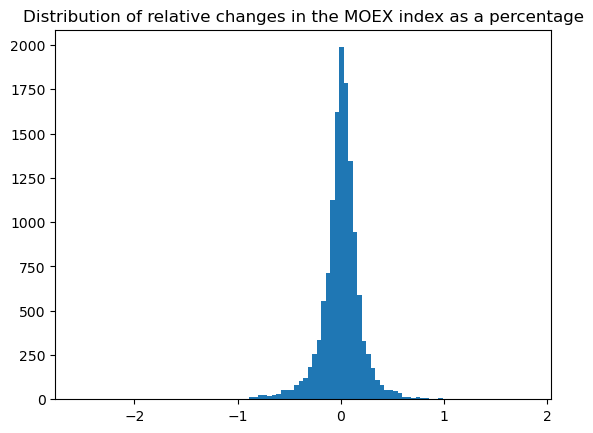

In [38]:
plt.hist(global_df.imoex_price_diff_percent, bins=100)
plt.title('Distribution of relative changes in the MOEX index as a percentage')
plt.show()

> **Comment:** It is easy to see that the distribution turned out to be quite logical: symmetrical and with a strong kurtosis at zero

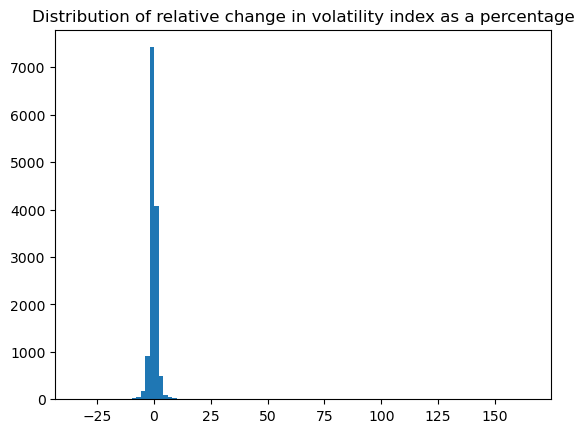

In [39]:
plt.hist(global_df.rvi_price_diff_percent, bins=100)
plt.title('Distribution of relative change in volatility index as a percentage')
plt.show()

> **Comment:** The distribution turned out to be almost symmetrical (though with some very small outliers) and with a very strong kurtosis at zero

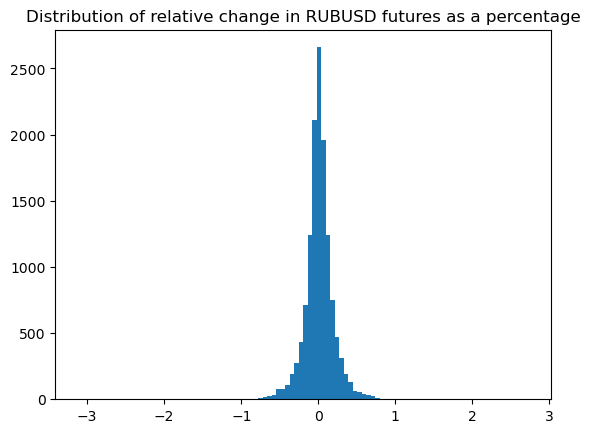

In [40]:
plt.hist(global_df.usd_price_diff_percent, bins=100)
plt.title('Distribution of relative change in RUBUSD futures as a percentage')
plt.show()

> **Comment:** It is easy to see that the distribution turned out to be quite logical: symmetrical and with a strong kurtosis at zero

> **P.S.** We took futures because it has a wider trading window than spot RUBUSD

## Export and Check

In [99]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True
global_df.to_sql('global_trade', con=conn, if_exists='replace', index=False) 
conn.close()

In [102]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

dataframe = pd.read_sql_query('SELECT * FROM global_trade', conn)
conn.close()

print(dataframe.shape)
dataframe.head()

(13304, 20)


,website,section,url,header,body,tags,body_length,datetime,imoex_price_release,imoex_price_lag_30,rvi_price_release,rvi_price_lag_30,usd_price_release,usd_price_lag_30,imoex_price_diff,imoex_price_diff_percent,rvi_price_diff,rvi_price_diff_percent,usd_price_diff,usd_price_diff_percent
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,2166.77,2168.03,40.45,40.26,70352.0,69975.0,1.26,0.058151,-0.19,-0.469716,-377.0,-0.535877
1,РИА,Экономика,https://ria.ru/20230103/avtomobili-1842908567....,Минпромторг спрогнозировал рост производства а...,Минпромторг прогнозирует в наступившем году ...,"['Экономика', 'Авто', 'Денис Мантуров', 'Росси...",808,2023-01-03 10:20:00,2166.37,2167.18,40.45,40.25,70264.0,70008.0,0.81,0.037390,-0.20,-0.494438,-256.0,-0.364340
2,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/879539,Рынок акций РФ открылся ростом индекса МосБирж...,- Рынок акций РФ открылся во вторник ростом ...,['Московская биржа'],1249,2023-01-03 10:22:00,2166.08,2166.96,40.45,40.24,70176.0,70017.0,0.88,0.040626,-0.21,-0.519159,-159.0,-0.226573
3,РИА,Экономика,https://ria.ru/20230103/nissan-1842909188.html,"""АвтоВАЗу"" передадут активы Nissan в России","Подведомственное Минпромторгу ФГУП ""НАМИ"" пе...","['Экономика', 'Авто', 'Денис Мантуров', 'Минис...",1414,2023-01-03 10:29:00,2168.32,2168.95,39.86,40.22,70051.0,70144.0,0.63,0.029055,0.36,0.903161,93.0,0.132760
4,Kommersant,Финансы,https://www.kommersant.ru/doc/5757823,"Индекс Мосбиржи растет на 0,5% на первой торго...",Индекс Московской биржи на открытии торгов рас...,None,598,2023-01-03 10:31:00,2168.03,2170.54,39.89,40.13,69940.0,70053.0,2.51,0.115773,0.24,0.601655,113.0,0.161567
